# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: 44
* Students: Nikolai Orgland, Diego Debruyn, Yann Morize, Silvan Stettler
* Dataset: Swiss National Council

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline
import numpy as np

# Weighted adjacency matrix
adjacency_weighted = np.load("adjacency.npy")

# Binary matrices created using different thresholds
filenames = ["adjacency_0.1", "adjacency_0.3", "adjacency_0.5", "adjacency_0.7", "adjacency_0.9"]

adjacencies_binary =  [np.load(file+".npy") for file in filenames]
n_nodes =  np.asarray([a.shape[0] for a in adjacencies_binary])
n_edges =  np.asarray([np.sum(a)/2 for a in adjacencies_binary])
thresholds = np.linspace(0.1, 0.9, 5)

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency =  adjacency_weighted
n_nodes =  adjacency_weighted.shape[0]

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
k_i = np.sum(adjacency, axis=1)

row = np.arange(200)  # row coordinates
col = np.arange(200)  # column coordinates
D = sparse.coo_matrix((k_i, (row, col)), shape=(200,200))
D_sqrt = D.power(-0.5).toarray()
laplacian_combinatorial_array =  D.toarray()-adjacency 
laplacian_normalized_array =  D_sqrt @ laplacian_combinatorial_array @ D_sqrt 

In [5]:
# Store matrix in crs format
laplacian_combinatorial = scipy.sparse.csr_matrix(laplacian_combinatorial_array)
laplacian_normalized = scipy.sparse.csr_matrix(laplacian_normalized_array)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [6]:
laplacian =  laplacian_normalized

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [7]:
L=laplacian.toarray()

In [8]:
vals, vecs = np.linalg.eigh(L)
# The eigenvalues are already sorted with this function
D = np.diag(vals)
# Test to verify that the eigendecomposition was done correctly
TEST = np.allclose(L,np.matrix(vecs) @ np.matrix(D) @ np.matrix(np.transpose(vecs)))

eigenvalues =  np.round(vals,10)
eigenvectors =  np.round(vecs,10)

assert eigenvectors.shape == (n_nodes, n_nodes)
print('The eigendeconmosition is correct: {0:}'.format(TEST))

The eigendeconmosition is correct: True


Justify your choice of eigensolver.

**As our matrix is dense and not sparse (we have 100% density), we opted for using the numpy solver instead of the sparse solver from the scipy library.**

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**S is the incidence matrix. $S^Tx$ gives us the gradient of x.**

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Considering the eigendecomposition of L we obtain:**

**$\lambda_k = u_k^\top L u_k = u_k^\top S S^\top u_k = (S^\top u_k)^\top (S^\top u_k) = \| S^\top u_k \|_2^2$**

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**This quadratic form is a measure of how smooth the signal x is. It is the square norm of the gradient.**

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**$u_0$ is called the constant vector and is the first eigenvector of the Laplacian. As we can see on the plots below: the entries of the constant vector for the combinatorial Laplacian is constant (7x10^(-2)). However, the constant vector for normalized Laplacian has big fluctuations around (-7x10^-2) . We think that this is due to the accumulation of numerical roundings during the computation.**

Difference between max and min values of u0_norm = 0.03179


Text(0.5,1,'Entries of constant vector u0 from combinatorial Laplacian \n ')

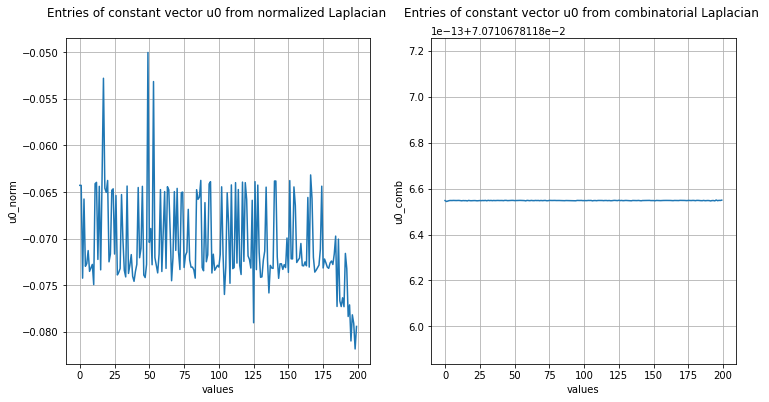

In [25]:
valsnorm, vecsnorm = np.linalg.eigh(laplacian_normalized_array)
valscomb, vecscomb = np.linalg.eigh(laplacian_combinatorial_array)

deviation = (np.max(vecsnorm[:,0]))-(np.min (vecsnorm[:,0]))
print('Difference between max and min values of u0_norm = {0:.5f}'.format(deviation))

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(row, vecsnorm[:,0])
plt.grid(True)
plt.xlabel('values')
plt.ylabel('u0_norm')
plt.title('Entries of the constant vector u0 for the normalized Laplacian \n')
plt.subplot(122)
plt.plot(row, vecscomb[:,0])
plt.grid(True)
plt.xlabel('values')
plt.ylabel('u0_comb')
plt.title('Entries of the constant vector u0 for the combinatorial Laplacian \n ')

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

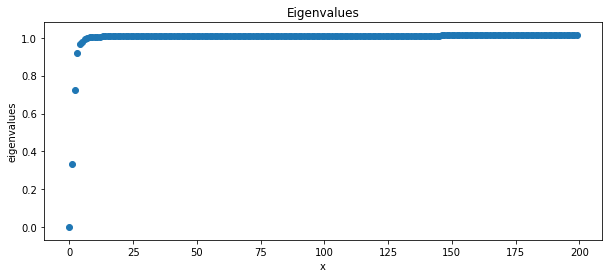

In [10]:
plt.figure(figsize=(10, 4))
plt.scatter(row, eigenvalues)
plt.xlabel('k')
plt.ylabel('eigenvalues')
plt.title('Eigenvalues')
plt.show()

**We observere that there is no single minimum eigenvalue which is equal to zero. Furthemore, we see that the eigenvalues converge very fast to 1: There are only two eigenvalues between 0 and 0.8. The remaining eigenvalues are very close to 1. Therefore, no obvious clusters can be defined a priori.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [11]:
connect = np.count_nonzero(eigenvalues == 0)
print ("The graph has {} connected component(s)".format(connect)) 

The graph has 1 connected component(s)


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**We have for the largest eigenvalue of the normalized Laplacian: $\lambda_{N-1}= \frac{N}{N-1}$ for a complete graph and $\lambda_{N-1}=2$ for a bipartite graph. As we see in the next cell below, our $\lambda_{N-1}$ is much closer to a complete graph than to a bipartite one.**

In [26]:
# Case: normalized Laplacian
Complete_norm = n_nodes/(n_nodes-1)
lamb_norm = max (valsnorm)
Bipartite_norm= 2
print('N/(N-1) = {0:.3f}'.format(Complete_norm))
print('lambda_norm max = {0:.3f}'.format(lamb_norm))
print('Bipartie = {0}'.format(Bipartite_norm))
print()
print("Indeed: {0:.3f} < {1:.3f} < {2}" .format(Complete_norm, lamb_norm,Bipartite_norm))

N/(N-1) = 1.005
lambda_norm max = 1.015
Bipartie = 2

Indeed: 1.005 < 1.015 < 2


**For the combinatorial Laplacian: $\lambda_{N-1}= \frac{N}{N-1}*\Delta(G)$ for a complete graph and $\lambda_{N-1}=2*\Delta(G)$ for a bipartite graph. With $\Delta(G)=max (k_i).$ Also here, we observe that the vale of $\lambda_{N-1}$ is much closer to the one of a complete graph**

In [13]:
# Case: combinatorial Laplacian
Complete_comb=n_nodes/(n_nodes-1)* max(k_i)
lamb_comb = max (valscomb)
Bipartite_comb= 2*max(k_i)
print('N/(N-1)*∆(G) = {0:.3f}'.format(Complete_comb))
print('lambda_comb max = {0:.3f}'.format(lamb_comb))
print("Bipartie = {0:.3f}".format(Bipartite_comb))
print()
print("Indeed: {0:.3f} < {1:.3f} < {2:.3f}".format(Complete_comb, lamb_comb,Bipartite_comb))

N/(N-1)*∆(G) = 118.587
lambda_comb max = 118.734728
Bipartie = 235.988

Indeed: 118.587 < 118.735 < 235.988


## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Graph embeddings such as Laplacian eigenmaps allow us to visualize graphs with high dimensionality in lower dimensions (2 or 3), without loosing the similarity between the original data points. By applying this method, a visual similarity analysis (by the human eye) is faciliated significantly.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

**Embedding by following the algorithm of the reference "Laplacian Eigenmaps for Dimensionality Reduction" on Moodle: For d = 2, the optimal embedding is acheived by taking the first d = 2 eigenvectors belonging to non-zero eigenvalues, such that $x_i = (f_1(i), f_2(i))$**

In [14]:
# Compute the non-zero eigenvectors of the normalized and combinatorial Laplacian. 
# We know that only the first eigenvalue is zero, hence we need the first k=3 eigenvectors. 
# Since lambda0 <= lambda1 <= lambda2, the partial eigenvalue decomposition from scipy.sparse 
# should return the three smallest eigenvalues
w_comb, v_comb = scipy.sparse.linalg.eigsh(laplacian_combinatorial, k=3, which='SM')
w_norm, v_norm = scipy.sparse.linalg.eigsh(laplacian_normalized, k=3, which='SM')

In [15]:
# Choose first two nonzero eigenvectors
x_embed_comb = v_comb[:,1:3]
x_embed_norm = v_norm[:,1:3]

Plot the nodes embedded in 2D. Comment on what you see.

Text(0.5,1,'Normalized Laplacian eigenmap (d = 2)')

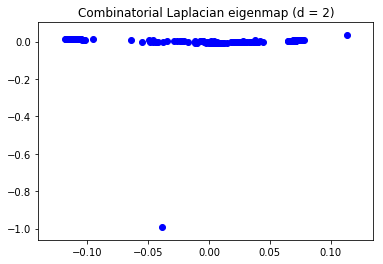

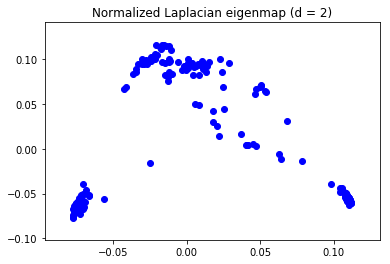

In [16]:
# Without normalization
fig, ax = plt.subplots()
ax.scatter(x_embed_comb[:,0], x_embed_comb[:,1], color='b')
ax.set_title('Combinatorial Laplacian eigenmap (d = 2)')

# With normalization
fig, ax = plt.subplots()
ax.scatter(x_embed_norm[:,0], x_embed_norm[:,1], color='b')
ax.set_title('Normalized Laplacian eigenmap (d = 2)')

**With normalization, we obtain a plot which allows us much more to distinguish differences in similarity between the points than without normalization. Therefore, we decide to keep the plot with normalization.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**In general, the embedding (e.g. laplacian eigenmaps) preserves the local information, such as similairties between the original data points - which in our case are nodes. However, extreme outliners might not be preserved to the benefit preserving the local clusters.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

We chose k=d=2 .It makes sense and could leed to left/rigt clustering. However no clear gap is observed in the eigenvalues and no clear right/left cluster is detected.
d=2 for vizualization reasons.

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

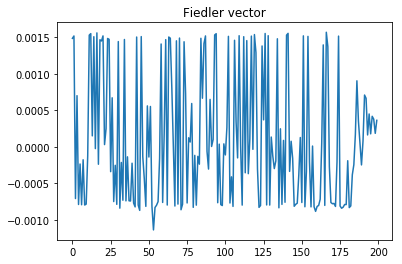

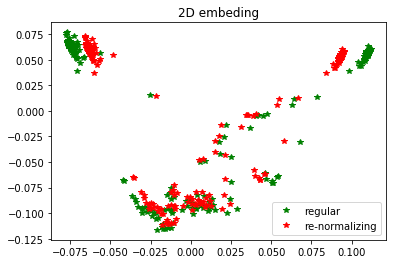

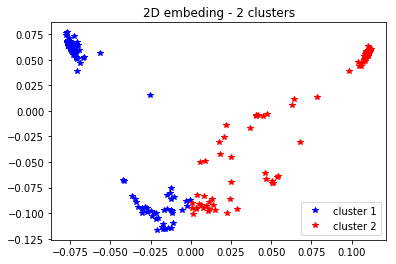

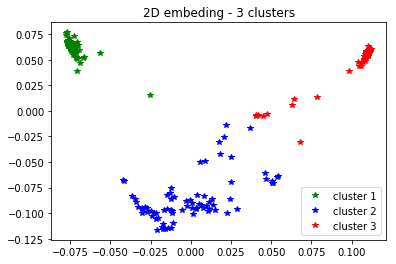

In [17]:
# Fiedler vector
plt.figure()
plt.title('Fiedler vector')
plt.plot(row, vecs[:,1]/k_i)

# Plot the 2D embedding
fig, ax = plt.subplots()

# For the k = 2 case: The sign of the elements of the Fiedler vector can be used to partition the graph
test=vecs[:,1] < 0

graph_d_3=vecs[:,0:3]

# We "re-normalize" the eigenvectors by their degrees
graph_d_3_norm=vecs[:,0:3]*np.power([D[1,1],D[2,2],D[3,3]],1/2)

ax.plot(graph_d_3[:,1],graph_d_3[:,2],'*g',label='regular')
ax.plot(graph_d_3_norm[:,1],graph_d_3_norm[:,2],'*r',label='re-normalizing')
plt.title('2D embeding')
ax.legend()

# For the case of 2 clusters: Use the signs of the Fiedler vector elements
fig, ax1 = plt.subplots(nrows=1,ncols=1, sharey=True)
ax1.plot(graph_d_3[test,1],graph_d_3[test,2],'*b',label='cluster 1')
ax1.plot(graph_d_3[~test,1],graph_d_3[~test,2],'*r',label='cluster 2')
plt.title('2D embeding - 2 clusters (Fiedler vector)')
ax1.legend()

# For the case of 3 clusters: KMeans to find clusters
fig, ax1 = plt.subplots(nrows=1,ncols=1, sharey=True)
clustering = KMeans(n_clusters=3,random_state=0).fit(graph_d_3)
group1=(clustering.labels_==0)
group2=(clustering.labels_==1)
group3=(clustering.labels_==2)

ax1.plot(graph_d_3[group1,1],graph_d_3[group1,2],'*g',label='cluster 1')
ax1.plot(graph_d_3[group2,1],graph_d_3[group2,2],'*b',label='cluster 2')
ax1.plot(graph_d_3[group3,1],graph_d_3[group3,2],'*r',label='cluster 3')
plt.title('2D embeding - 3 clusters (K-Means)')
ax1.legend()

**We decide to keep the re-normalized eigenvectors**

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [18]:
cluster=test*1
order=np.argsort(cluster)
# We reorder the adjacency matrix
adjacency_temp=adjacency[:,order]
adjacency_reordered=adjacency_temp[order,:]

**Nothing is expected to change as the graph is kept the same. We verifiy this by recomputing below the Fiedler vector and perform reclusturing with the newly ordered adjacency matrix.**

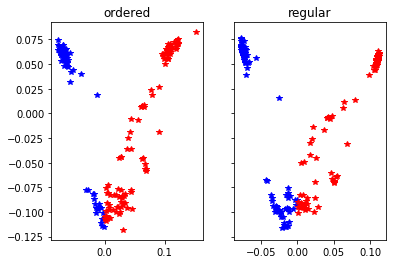

In [27]:
# We recompute the Fiedler vector and perform the reclustering with the new adjacency matrix in order to verify
# that the graph still is the same

k_i = np.sum(adjacency_reordered, axis=1)

D = sparse.coo_matrix((k_i, (row, col)), shape=(200,200))
D_sqrt = D.power(-0.5).toarray()

laplacian_combinatorial_array_bis =  D.toarray()-adjacency 
laplacian_normalized_array_bis =  D_sqrt @ laplacian_combinatorial_array_bis @ D_sqrt 
L= scipy.sparse.csr_matrix(laplacian_normalized_array_bis)
L=L.toarray()
vals_ordered, vecs_ordered = np.linalg.eigh(L)

test_ordered=vecs_ordered[:,1]<0
graph_d_3_ordered=vecs_ordered[:,0:3]

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, sharey=True)

ax1.set_title('ordered')
ax1.plot(graph_d_3_ordered[test_ordered,1],graph_d_3_ordered[test_ordered,2],'*b',label='cluster 1')
ax1.plot(graph_d_3_ordered[~test_ordered,1],graph_d_3_ordered[~test_ordered,2],'*r',label='cluster 2')

ax2.set_title('regular')
ax2.plot(graph_d_3[test,1],graph_d_3[test,2],'*b',label='cluster 1')
ax2.plot(graph_d_3[~test,1],graph_d_3[~test,2],'*r',label='cluster 2')

**One observe slighlty different 2D representation but the main frame is still similar**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

The correct assignement rate is 0.74
The uncorrect assignement rate is 0.135


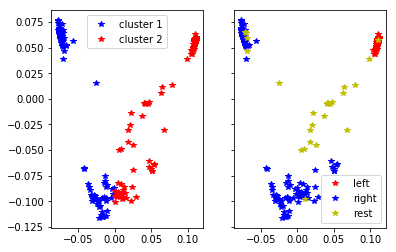

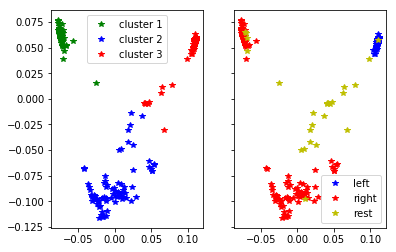

In [20]:
# We import the real clusters (ground truth) which are the association of the concillors to either a 
# left-wing or right-wing political party. There are also some concillors that belong to parties that are typically
# said to be centrist.
real_clus=np.load('clustering.npy')
gauche=(real_clus == -1)
droite=(real_clus == 1)

# For 2 clusters
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True)

ax1.plot(graph_d_3[test,1],graph_d_3[test,2],'*b',label='cluster 1')
ax1.plot(graph_d_3[~test,1],graph_d_3[~test,2],'*r',label='cluster 2')
ax1.legend()

ax2.plot(graph_d_3[gauche,1],graph_d_3[gauche,2],'*r',label='left')
ax2.plot(graph_d_3[droite,1],graph_d_3[droite,2],'*b',label='right')
ax2.plot(graph_d_3[~(gauche|droite),1],graph_d_3[~(gauche|droite),2],'*y',label='rest')
ax2.legend()

# For 3 clusters

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True)
clustering = KMeans(n_clusters=3,random_state=0).fit(graph_d_3)
group1=(clustering.labels_==0)
group2=(clustering.labels_==1)
group3=(clustering.labels_==2)

ax1.plot(graph_d_3[group1,1],graph_d_3[group1,2],'*g',label='cluster 1')
ax1.plot(graph_d_3[group2,1],graph_d_3[group2,2],'*b',label='cluster 2')
ax1.plot(graph_d_3[group3,1],graph_d_3[group3,2],'*r',label='cluster 3')
ax1.legend()

ax2.plot(graph_d_3[gauche,1],graph_d_3[gauche,2],'*b',label='left')
ax2.plot(graph_d_3[droite,1],graph_d_3[droite,2],'*r',label='right')
ax2.plot(graph_d_3[~(gauche|droite),1],graph_d_3[~(gauche|droite),2],'*y',label='rest')
ax2.legend()

match=np.sum((gauche&~test)|(droite&test))/n_nodes
unmatch=np.sum((gauche&test)|(droite&~test))/n_nodes

print('The correct assignement rate is {0:}'.format(match))
print('The uncorrect assignement rate is {0:}'.format(unmatch))

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

Text(0.5,1,'Normalized Laplacian eigenmap (d = 2)')

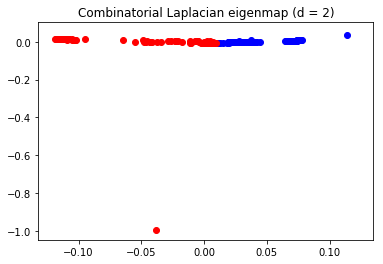

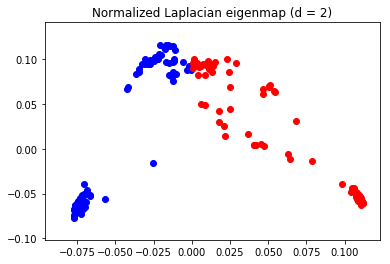

In [21]:
fig, ax = plt.subplots()
ax.scatter(x_embed_comb[test,0], x_embed_comb[test,1], color='b')
ax.scatter(x_embed_comb[~test,0], x_embed_comb[~test,1], color='r')
ax.set_title('Combinatorial Laplacian eigenmap (d = 2)')

fig, ax = plt.subplots()
ax.scatter(x_embed_norm[test,0], x_embed_norm[test,1], color='b')
ax.scatter(x_embed_norm[~test,0], x_embed_norm[~test,1], color='r')
ax.set_title('Normalized Laplacian eigenmap (d = 2)')

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**We know from theory that for an ideal graph with k unconnected components the k first eigenvectors are indicator vectors of the connected components. By using these eigenvectors as features we can thus find the connected clusters by applying k-means.**

**Even though our graph is not ideal (as it is completely connected), we can still use these eigenvectors to find our connected clusters. The entries of the eigenvectors will not however not be only 0 or 1 as in the ideal case**

**For solving the embedding problem, we minimized the cost function $\sum_{ij}W_{ij}(y_i-y_j)^2$ which we found in the references on Moodle (*Laplacian Eigenmaps for Dimensionality Reduction and Data Representation, chapter 3.1*). The solution of the minimization of the cost function yields the eigenvector matrix of the smallest eigenvectors, which we used as the features later clustering with k-Means for this milestone. While the criteria that led to the use of this cost function are very reasonable (points that are close together in the original data are close also in the embedded data), other cost functions could maybe also be used. The features that minimize this cost function might be different from the eigenvectors of the laplacion used that were used in this case. So yes, other features could also be used for clustering **